In [3]:
#Q1
#Random seed?
#Random state for loading dataset?
#Do we need to exclude numbers/punctuation as well?

import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

#Vectorizer
analyzer = CountVectorizer().build_analyzer()
tfidf_transformer = TfidfTransformer()

combined_stopwords = set.union(set(stopwords.words('english')),set(punctuation))


def stem_rmv_punc_nolem(doc):
    return (word for word in analyzer(doc) if word not in combined_stopwords and not word.isdigit())

#Download dataset
dataset = fetch_20newsgroups(subset='all', categories = categories, shuffle = True, random_state = 0, remove=('headers','footers')) 

count_vect = CountVectorizer(min_df=3,analyzer=stem_rmv_punc_nolem, stop_words='english')

X_counts = count_vect.fit_transform(dataset.data)
X_tfidf = tfidf_transformer.fit_transform(X_counts)

print("X_tfidf shape: ", X_tfidf.shape)

X_tfidf shape:  (7882, 21909)


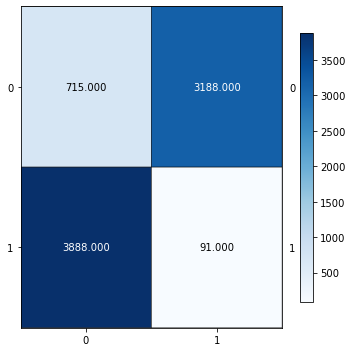

In [8]:
#Q2
#Get labels to verify k means accuracy

from sklearn.cluster import KMeans
from plotmat import plot_mat
from sklearn.metrics.cluster import contingency_matrix

dataset_targets_bin = dataset.target.copy()
for i in range(len(dataset_targets_bin)):
    if dataset.target[i] in [0,1,2,3]:
        dataset_targets_bin[i] = 0
    else:
        dataset_targets_bin[i] = 1

kmeans_clf = KMeans(n_clusters=2, max_iter=1500, random_state=0, n_init=50)
kmeans_clf.fit(X_tfidf)
km_cont_mat = contingency_matrix(dataset_targets_bin, kmeans_clf.labels_)

plot_mat(km_cont_mat, size=(5,5))
        

In [10]:
#Q3

#Are these values expected?
from sklearn import metrics
print("Homogeneity score: ", metrics.homogeneity_score(dataset_targets_bin, kmeans_clf.labels_))
print("Completeness score: ", metrics.completeness_score(dataset_targets_bin, kmeans_clf.labels_))
print("V_measure score: ", metrics.v_measure_score(dataset_targets_bin, kmeans_clf.labels_))
print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(dataset_targets_bin, kmeans_clf.labels_))
print("Adjusted Mutual Information Score: ", metrics.adjusted_mutual_info_score(dataset_targets_bin, kmeans_clf.labels_))


Homogeneity score:  0.5600025412974119
Completeness score:  0.5716557539454379
V_measure score:  0.5657691483417876
Adjusted Rand Index score:  0.6327475635535726
Adjusted Mutual Information Score:  0.5657289846874574


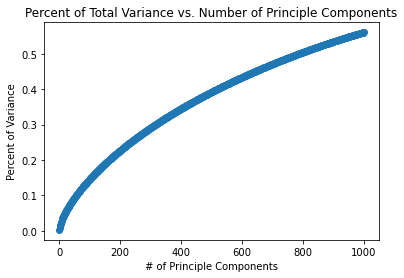

In [10]:
#Q4 
#Random state?
#Is this plot right?

from sklearn.decomposition import TruncatedSVD, NMF
import numpy as np

variances = []
r_vals = np.arange(1, 1001)

trunc_svd = TruncatedSVD(n_components=1000, random_state=0)
X_svd = trunc_svd.fit_transform(X_tfidf)

variances = trunc_svd.explained_variance_ratio_

plt.scatter(r_vals, np.cumsum(variances))
plt.xlabel("# of Principle Components")
plt.ylabel("Percent of Variance")
plt.title("Percent of Total Variance vs. Number of Principle Components")
plt.show()

In [12]:

#Q5
r_vals_5 = [1,2,3,5,10,20,50,100,300]
metric_scores_svd = []
metric_scores_nmf = []

for r in r_vals_5:
    nmf_model = NMF(n_components=r, init='random', random_state=0, max_iter=1000)
    nmf_red = nmf_model.fit_transform(X_tfidf)
    svd_red = X_svd[:,:r]
    
    kmeans_clf.fit(nmf_red)
    metric_scores_nmf.append((metrics.homogeneity_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.completeness_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.v_measure_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_rand_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_mutual_info_score(dataset_targets_bin, kmeans_clf.labels_)))
    kmeans_clf.fit(svd_red)
    metric_scores_svd.append((metrics.homogeneity_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.completeness_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.v_measure_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_rand_score(dataset_targets_bin, kmeans_clf.labels_),
                              metrics.adjusted_mutual_info_score(dataset_targets_bin, kmeans_clf.labels_)))

KeyboardInterrupt: 

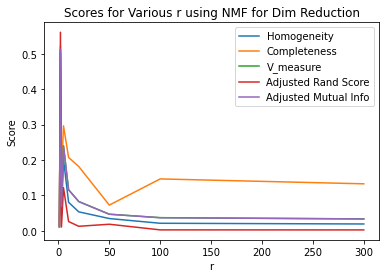

In [6]:
plt.plot(r_vals_5, metric_scores_nmf)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("r")
plt.ylabel("Score")
plt.title("Scores for Various r using NMF for Dim Reduction")
plt.show()

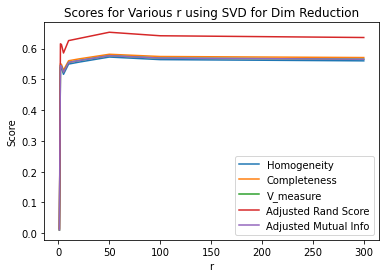

In [7]:
plt.plot(r_vals_5, metric_scores_svd)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("r")
plt.ylabel("Score")
plt.title("Scores for Various r using SVD for Dim Reduction")
plt.show()

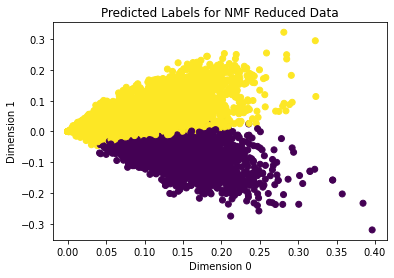

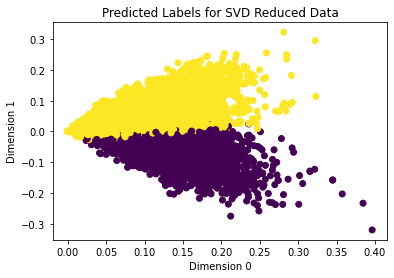

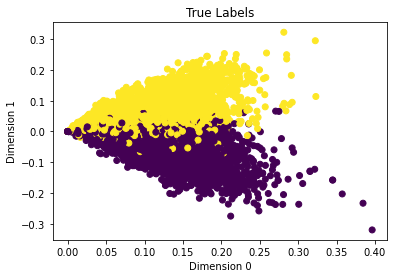

In [8]:
#Q7

nmf_best_k = 2
svd_best_k = 50

reduced_data = X_svd[:,:2]
nmf_model = NMF(n_components=nmf_best_k, init='random', random_state=0, max_iter=1000)
nmf_red = nmf_model.fit_transform(X_tfidf)
kmeans_clf.fit(nmf_red)
nmf_labels = kmeans_clf.labels_

svd_red = X_svd[:,:svd_best_k]
kmeans_clf.fit(svd_red)
svd_labels = kmeans_clf.labels_

plt.scatter(reduced_data[:,0], reduced_data[:,1], c=nmf_labels)
plt.title("Predicted Labels for NMF Reduced Data")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.show()

plt.scatter(reduced_data[:,0], reduced_data[:,1], c=svd_labels)
plt.title("Predicted Labels for SVD Reduced Data")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.show()

plt.scatter(reduced_data[:,0], reduced_data[:,1], c=dataset_targets_bin)
plt.title("True Labels")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.show()



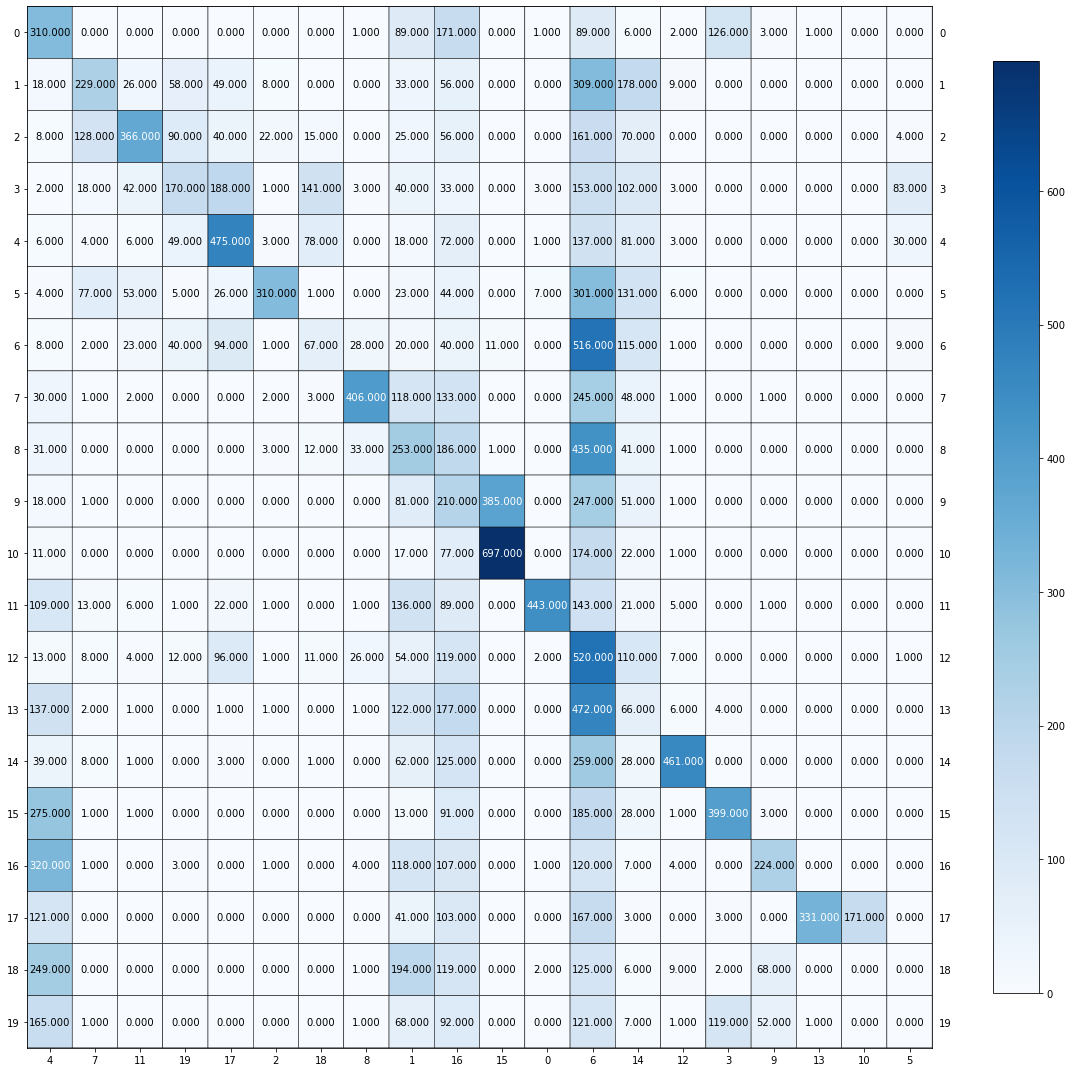

Homogeneity score:  0.31630458145750995
Completeness score:  0.3682552023183464
V_measure score:  0.3403086491478565
Adjusted Rand Index score:  0.10379799750286293
Adjusted Mutual Information Score:  0.3380068278889245


In [13]:
#Q9
#get all 20 categories this time
full_dataset = fetch_20newsgroups(subset='all', shuffle = True, random_state = 0, remove=('headers','footers'))
full_count_vect = CountVectorizer(min_df=3,analyzer=stem_rmv_punc_nolem, stop_words='english')
full_X_counts = full_count_vect.fit_transform(full_dataset.data)
full_X_tfidf = tfidf_transformer.fit_transform(full_X_counts)

#using SVD with r=50 - best results from earlier
full_trunc_svd = TruncatedSVD(n_components=1000, random_state=0)
full_X_svd = full_trunc_svd.fit_transform(full_X_tfidf)
full_svd_red = full_X_svd[:,:50]

#k-means w/20 clusters
full_kmeans_clf = KMeans(n_clusters=20, max_iter=1500, random_state=0, n_init=50)
full_kmeans_clf.fit(full_svd_red)

#metrics!
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

cm = contingency_matrix(full_dataset.target, full_kmeans_clf.labels_)
rows, cols=linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

print("Homogeneity score: ", metrics.homogeneity_score(full_dataset.target, full_kmeans_clf.labels_))
print("Completeness score: ", metrics.completeness_score(full_dataset.target, full_kmeans_clf.labels_))
print("V_measure score: ", metrics.v_measure_score(full_dataset.target, full_kmeans_clf.labels_))
print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(full_dataset.target, full_kmeans_clf.labels_))
print("Adjusted Mutual Information Score: ",metrics.adjusted_mutual_info_score(full_dataset.target, full_kmeans_clf.labels_))


In [10]:
#Q10
#double check - still doing this will the full 20-category dataset?
r_vals = [2,50]

for i in r_vals:
    nmf_KL = NMF(n_components=i, init='random', random_state=0, max_iter=1000, beta_loss = "kullback-leibler", solver='mu')
    nmf_red_KL = nmf_KL.fit_transform(full_X_tfidf)
    kmeans_clf_KL = KMeans(n_clusters=20, max_iter=1500, random_state=0, n_init=50)
    kmeans_clf_KL.fit(nmf_red_KL)
    print()
    print("r = " + str(i))
    print("Homogeneity score: ", metrics.homogeneity_score(full_dataset.target, kmeans_clf_KL.labels_))
    print("Completeness score: ", metrics.completeness_score(full_dataset.target, kmeans_clf_KL.labels_))
    print("V_measure score: ", metrics.v_measure_score(full_dataset.target, kmeans_clf_KL.labels_))
    print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(full_dataset.target, kmeans_clf_KL.labels_))
    print("Adjusted Mutual Information Score: ",metrics.adjusted_mutual_info_score(full_dataset.target, kmeans_clf_KL.labels_))

    


r = 2
Homogeneity score:  0.19676527887644293
Completeness score:  0.2136834606423116
V_measure score:  0.2048756966527202
Adjusted Rand Index score:  0.0604569445452653
Adjusted Mutual Information Score:  0.20217480540664073

r = 50
Homogeneity score:  0.30640759897200137
Completeness score:  0.47873972223954575
V_measure score:  0.3736610566220568
Adjusted Rand Index score:  0.05415577061481132
Adjusted Mutual Information Score:  0.37118024804272814


In [14]:
#Q11 

import umap

n_vals = [2,5,10,50,100,1000]
metric_scores_euc = []
metric_scores_cos = []


for i in n_vals:
    print("working on reducing for n = " + str(i))
    reducer_euc = umap.UMAP(n_components=i, init='random', metric="euclidean")
    embedding_euc = reducer_euc.fit_transform(full_X_tfidf)
    reducer_cos = umap.UMAP(n_components=i, init='random', metric="cosine")
    embedding_cos = reducer_cos.fit_transform(full_X_tfidf)
    
    col_mean = np.nanmean(embedding_cos, axis=0)
    inds = np.where(np.isnan(embedding_cos))
    embedding_cos[inds] = np.take(col_mean, inds[1])
    
    print("working on kmeans for n = " + str(i))
    kmeans_clf_euc = KMeans(n_clusters=20, max_iter=1500, random_state=0, n_init=50)
    kmeans_clf_euc.fit(embedding_euc)
    kmeans_clf_cos = KMeans(n_clusters=20, max_iter=1500, random_state=0, n_init=50)
    kmeans_clf_cos.fit(embedding_cos)
    
    metric_scores_euc.append((metrics.homogeneity_score(full_dataset.target, kmeans_clf_euc.labels_),
                              metrics.completeness_score(full_dataset.target, kmeans_clf_euc.labels_),
                              metrics.v_measure_score(full_dataset.target, kmeans_clf_euc.labels_),
                              metrics.adjusted_rand_score(full_dataset.target, kmeans_clf_euc.labels_),
                              metrics.adjusted_mutual_info_score(full_dataset.target, kmeans_clf_euc.labels_)))
    
    metric_scores_cos.append((metrics.homogeneity_score(full_dataset.target, kmeans_clf_cos.labels_),
                              metrics.completeness_score(full_dataset.target, kmeans_clf_cos.labels_),
                              metrics.v_measure_score(full_dataset.target, kmeans_clf_cos.labels_),
                              metrics.adjusted_rand_score(full_dataset.target, kmeans_clf_cos.labels_),
                              metrics.adjusted_mutual_info_score(full_dataset.target, kmeans_clf_cos.labels_)))

    
plt.plot(n_vals, metric_scores_euc)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("n_components")
plt.ylabel("Score")
plt.title("Scores for Various n_components Using UMAP w/Euclidean Metric")
plt.show()

plt.plot(n_vals, metric_scores_cos)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("n_components")
plt.ylabel("Score")
plt.title("Scores for Various n_components Using UMAP w/Cosine Metric")
plt.show()

working on reducing for n = 2


KeyboardInterrupt: 

In [16]:
#Q13
#How many components in UMAP reduction? What metric to use? Is it the best from above?

from sklearn.cluster import AgglomerativeClustering

umap_best_n = 5
umap_best_metric = 'cosine'

umap_reducer = umap.UMAP(n_components=umap_best_n, init='random', metric=umap_best_metric)
    
red_umap = umap_reducer.fit_transform(full_X_tfidf)
col_mean = np.nanmean(red_umap, axis=0)
inds = np.where(np.isnan(red_umap))
red_umap[inds] = np.take(col_mean, inds[1])


agg_clust_ward = AgglomerativeClustering(n_clusters=20, linkage='ward')
agg_clust_single = AgglomerativeClustering(n_clusters=20, linkage='single')

agg_clust_ward.fit(red_umap)
agg_clust_single.fit(red_umap)

print("Ward Linkage Scores")
print("Homogeneity score: ", metrics.homogeneity_score(full_dataset.target, agg_clust_ward.labels_))
print("Completeness score: ", metrics.completeness_score(full_dataset.target, agg_clust_ward.labels_))
print("V_measure score: ", metrics.v_measure_score(full_dataset.target, agg_clust_ward.labels_))
print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(full_dataset.target, agg_clust_ward.labels_))
print("Adjusted Mutual Information Score: ",metrics.adjusted_mutual_info_score(full_dataset.target, agg_clust_ward.labels_))

print()
print("Single Linkage Scores")
print("Homogeneity score: ", metrics.homogeneity_score(full_dataset.target, agg_clust_single.labels_))
print("Completeness score: ", metrics.completeness_score(full_dataset.target, agg_clust_single.labels_))
print("V_measure score: ", metrics.v_measure_score(full_dataset.target, agg_clust_single.labels_))
print("Adjusted Rand Index score: ", metrics.adjusted_rand_score(full_dataset.target, agg_clust_single.labels_))
print("Adjusted Mutual Information Score: ",metrics.adjusted_mutual_info_score(full_dataset.target, agg_clust_single.labels_))


C:\Users\Zoe\anaconda3\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 479 edges.
It has only fully disconnected 20 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


Ward Linkage Scores
Homogeneity score:  0.5531811079174291
Completeness score:  0.5800841461121151
V_measure score:  0.5663132960101679
Adjusted Rand Index score:  0.4163082810383901
Adjusted Mutual Information Score:  0.5648674649175116

Single Linkage Scores
Homogeneity score:  0.015956856815495562
Completeness score:  0.38841202191612717
V_measure score:  0.03065436211893167
Adjusted Rand Index score:  0.00046840972871960694
Adjusted Mutual Information Score:  0.02582613517513342


In [5]:
#Q14

#as in 13 - double check our best n and metric after 11 is resolved
import umap
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN

eps_vals = [.01,.1,.5,1]
metric_scores_DBSCAN = []
metric_scores_HDBSCAN = []


for eps in eps_vals:
    DBSCAN_clust = DBSCAN(min_samples=100, eps=eps)
    HDBSCAN_clust = HDBSCAN(min_cluster_size=100,cluster_selection_epsilon = eps)

    DBSCAN_clust.fit(red_umap)
    HDBSCAN_clust.fit(red_umap)
    
    metric_scores_DBSCAN.append((metrics.homogeneity_score(full_dataset.target, DBSCAN_clust.labels_),
                              metrics.completeness_score(full_dataset.target, DBSCAN_clust.labels_),
                              metrics.v_measure_score(full_dataset.target, DBSCAN_clust.labels_),
                              metrics.adjusted_rand_score(full_dataset.target, DBSCAN_clust.labels_),
                              metrics.adjusted_mutual_info_score(full_dataset.target, DBSCAN_clust.labels_)))
    
    metric_scores_HDBSCAN.append((metrics.homogeneity_score(full_dataset.target, HDBSCAN_clust.labels_),
                              metrics.completeness_score(full_dataset.target, HDBSCAN_clust.labels_),
                              metrics.v_measure_score(full_dataset.target, HDBSCAN_clust.labels_),
                              metrics.adjusted_rand_score(full_dataset.target, HDBSCAN_clust.labels_),
                              metrics.adjusted_mutual_info_score(full_dataset.target, HDBSCAN_clust.labels_)))

    
plt.plot(eps_vals, metric_scores_DBSCAN)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("Epsilon")
plt.ylabel("Score")
plt.title("Scores for Various Epsilons using DBSCAN")
plt.show()

plt.plot(eps_vals, metric_scores_HDBSCAN)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("Epsilon")
plt.ylabel("Score")
plt.title("Scores for Various Epsilon Using HDBSCAN")
plt.show()

#best one is .5 in both cases - getting metrics for that one
print("Best DBSCAN Scores")
print("Homogeneity score: ", metric_scores_DBSCAN[2][0])
print("Completeness score: ", metric_scores_DBSCAN[2][1])
print("V_measure score: ", metric_scores_DBSCAN[2][2])
print("Adjusted Rand Index score: ", metric_scores_DBSCAN[2][3])
print("Adjusted Mutual Information Score: ",metric_scores_DBSCAN[2][4])

print()
print("Single HDBSCAN Scores")
print("Homogeneity score: ", metric_scores_HDBSCAN[2][0])
print("Completeness score: ", metric_scores_HDBSCAN[2][1])
print("V_measure score: ", metric_scores_HDBSCAN[2][2])
print("Adjusted Rand Index score: ", metric_scores_HDBSCAN[2][3])
print("Adjusted Mutual Information Score: ",metric_scores_HDBSCAN[2][4])

ModuleNotFoundError: No module named 'hdbscan'

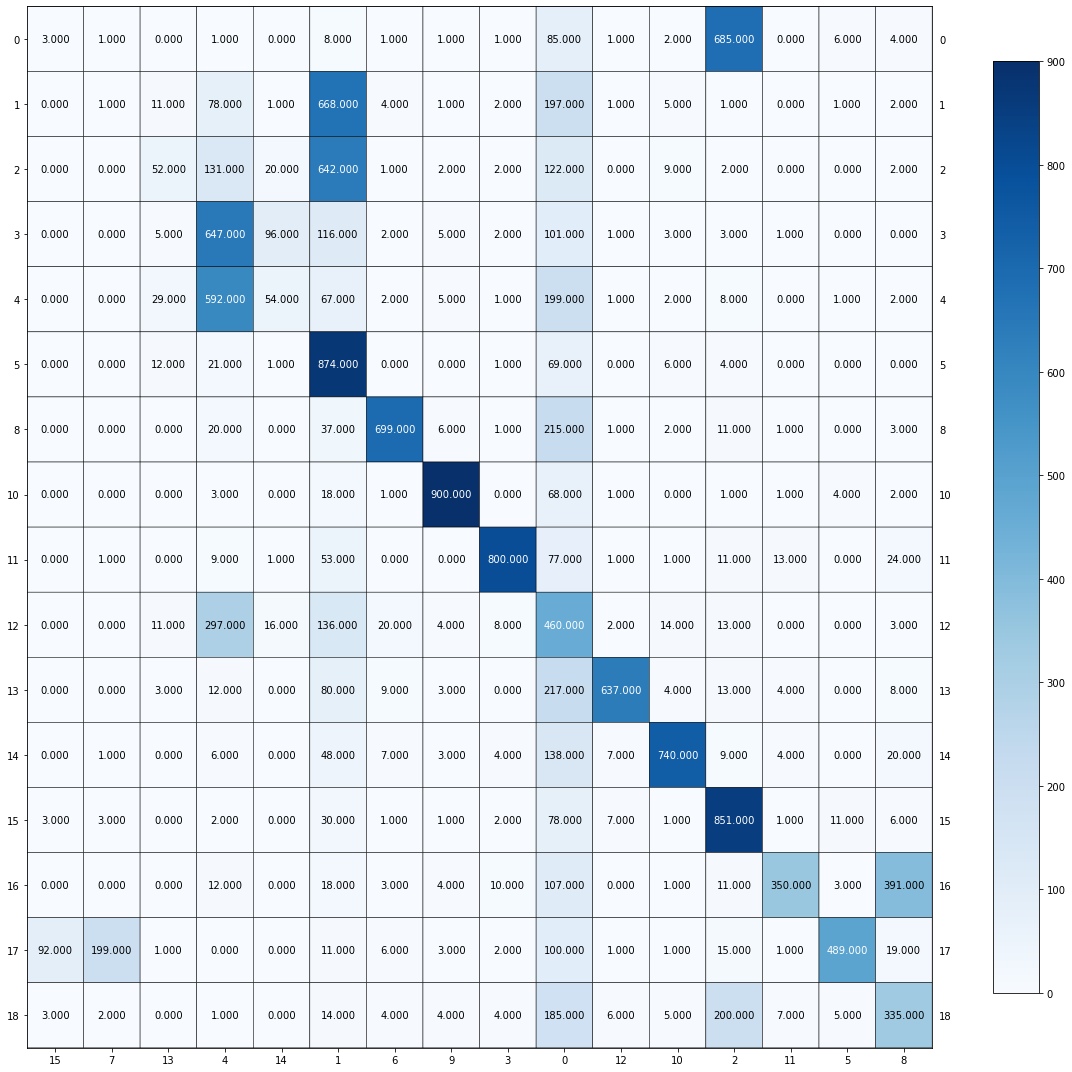

Estimated number of clusters:  15


In [26]:
# Q15
DBSCAN_clust = DBSCAN(min_samples=100, eps=.5)
DBSCAN_clust.fit(red_umap)

cm = contingency_matrix(full_dataset.target, DBSCAN_clust.labels_)
rows, cols=linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

#when label is -1, DBSCAN thinks the point is noise - so it might estimate fewer clusters than we actually have!
labels = DBSCAN_clust.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Estimated number of clusters: ", n_clusters_)

In [4]:
#Q16

#get data and vectorize

#Using the larger training dataset
import pandas
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from plotmat import plot_mat

#run at the console:
#pip install umap-learn
#import umap.umap_ as umap

bbc = pandas.read_csv('BBC_News_Train.csv')
categories = (bbc.Category.unique()).tolist()
targets = []
for i in bbc.Category:
    for j in range(0,len(categories)):
        if i == categories[j]:
            targets.append(j)
bbc['target'] = targets    

X_counts = count_vect.fit_transform(bbc.Text)
bbc_X_tfidf = tfidf_transformer.fit_transform(X_counts)
print("bbc_X_tfidf shape: ", bbc_X_tfidf.shape)

bbc_X_tfidf shape:  (1490, 10197)


working on reducing for n = 2
working on kmeans for n = 2
working on reducing for n = 5
working on kmeans for n = 5
working on reducing for n = 10
working on kmeans for n = 10
working on reducing for n = 50
working on kmeans for n = 50
working on reducing for n = 100
working on kmeans for n = 100
working on reducing for n = 1000
working on kmeans for n = 1000


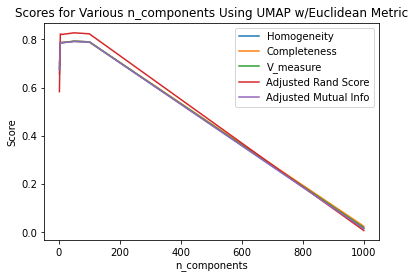

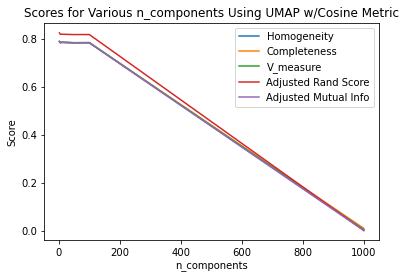

In [11]:
#Find best number of components and metric for UMAP reduction

import numpy as np

n_vals = [2,5,10,50,100,1000]
metric_scores_euc = []
metric_scores_cos = []


for i in n_vals:
    print("working on reducing for n = " + str(i))
    reducer_euc = umap.UMAP(n_components=i, init='random', metric="euclidean")
    embedding_euc = reducer_euc.fit_transform(bbc_X_tfidf)
    reducer_cos = umap.UMAP(n_components=i, init='random', metric="cosine")
    embedding_cos = reducer_cos.fit_transform(bbc_X_tfidf)
    
    col_mean = np.nanmean(embedding_cos, axis=0)
    inds = np.where(np.isnan(embedding_cos))
    embedding_cos[inds] = np.take(col_mean, inds[1])
    
    print("working on kmeans for n = " + str(i))
    kmeans_clf_euc = KMeans(n_clusters=5, max_iter=1500, random_state=0, n_init=50)
    kmeans_clf_euc.fit(embedding_euc)
    kmeans_clf_cos = KMeans(n_clusters=5, max_iter=1500, random_state=0, n_init=50)
    kmeans_clf_cos.fit(embedding_cos)
    
    metric_scores_euc.append((metrics.homogeneity_score(bbc.target, kmeans_clf_euc.labels_),
                              metrics.completeness_score(bbc.target, kmeans_clf_euc.labels_),
                              metrics.v_measure_score(bbc.target, kmeans_clf_euc.labels_),
                              metrics.adjusted_rand_score(bbc.target, kmeans_clf_euc.labels_),
                              metrics.adjusted_mutual_info_score(bbc.target, kmeans_clf_euc.labels_)))
    
    metric_scores_cos.append((metrics.homogeneity_score(bbc.target, kmeans_clf_cos.labels_),
                              metrics.completeness_score(bbc.target, kmeans_clf_cos.labels_),
                              metrics.v_measure_score(bbc.target, kmeans_clf_cos.labels_),
                              metrics.adjusted_rand_score(bbc.target, kmeans_clf_cos.labels_),
                              metrics.adjusted_mutual_info_score(bbc.target, kmeans_clf_cos.labels_)))

    
plt.plot(n_vals, metric_scores_euc)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("n_components")
plt.ylabel("Score")
plt.title("Scores for Various n_components Using UMAP w/Euclidean Metric")
plt.show()

plt.plot(n_vals, metric_scores_cos)
plt.legend(("Homogeneity","Completeness","V_measure", "Adjusted Rand Score", "Adjusted Mutual Info"))
plt.xlabel("n_components")
plt.ylabel("Score")
plt.title("Scores for Various n_components Using UMAP w/Cosine Metric")
plt.show()


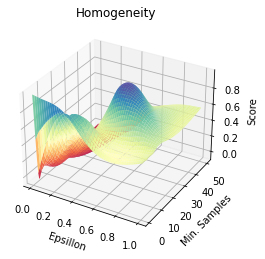

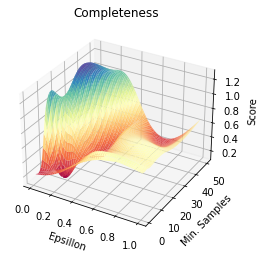

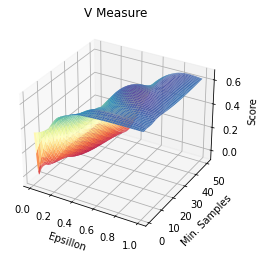

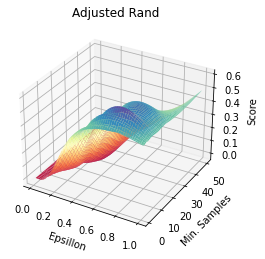

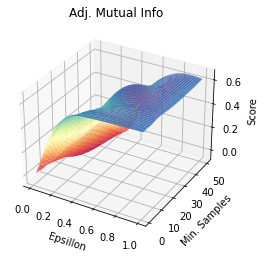

In [15]:
# Best n appears to be 5
# Find best parameters for DBSCAN
# Generate 3D surface plots for each metric against epsillon and min samples values
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

umap_reducer = umap.UMAP(n_components = 5, init = 'random', metric = 'cosine')
bbc_umap = umap_reducer.fit_transform(bbc_X_tfidf)

eps_vals = [.01,.1,.3,.5,1]
samples = [1,3,5,10,20,50]
metric_scores_DBSCAN = []

for eps in eps_vals:
    for sam in samples:
        DBSCAN_clust = DBSCAN(min_samples=sam, eps=eps)
        DBSCAN_clust.fit(bbc_umap)
        metric_scores_DBSCAN.append([metrics.homogeneity_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.completeness_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.v_measure_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.adjusted_rand_score(bbc.target, DBSCAN_clust.labels_),
                                     metrics.adjusted_mutual_info_score(bbc.target, DBSCAN_clust.labels_),eps,sam])
    

metricdata = np.array(metric_scores_DBSCAN)
metric_scores = ['Homogeneity', 'Completeness', 'V Measure', 'Adjusted Rand', 'Adj. Mutual Info']

for i in range(0,5):
    plotdata = metricdata[:, [i,5,6]]
    z, x, y = zip(*plotdata)
    z = list(map(float, z))
    grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
    ax.set_xlabel('Epsillon')
    ax.set_ylabel('Min. Samples')
    ax.set_zlabel('Score')
    ax.set_title(str(metric_scores[i]))
    plt.show()



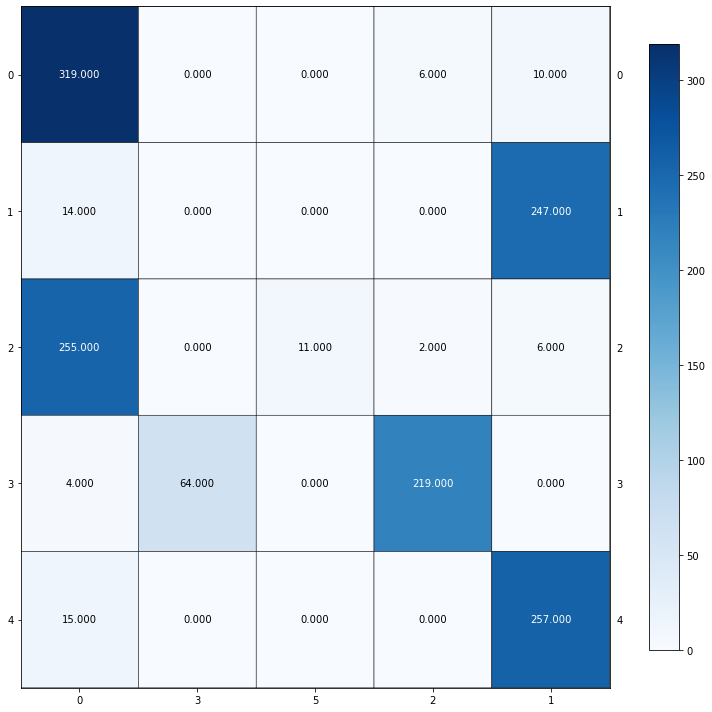

Estimated number of clusters:  6


In [28]:
# Contingency Matrix for best parameter combination
# Haven't confirmed these are the best values yet

umap_reducer = umap.UMAP(n_components = 5, init = 'random', metric = 'cosine')
bbc_umap = umap_reducer.fit_transform(bbc_X_tfidf)

DBSCAN_clust = DBSCAN(min_samples=5, eps=.9)
DBSCAN_clust.fit(bbc_umap)

cm = contingency_matrix(bbc.target, DBSCAN_clust.labels_)
rows, cols=linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(10,10))

#when label is -1, DBSCAN thinks the point is noise - so it might estimate fewer clusters than we actually have!
labels = DBSCAN_clust.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Estimated number of clusters: ", n_clusters_)